# 핵심 코어 함수 부분들을 최적화 시키자

## 속도 체크 !

# Apriori 알고리즘

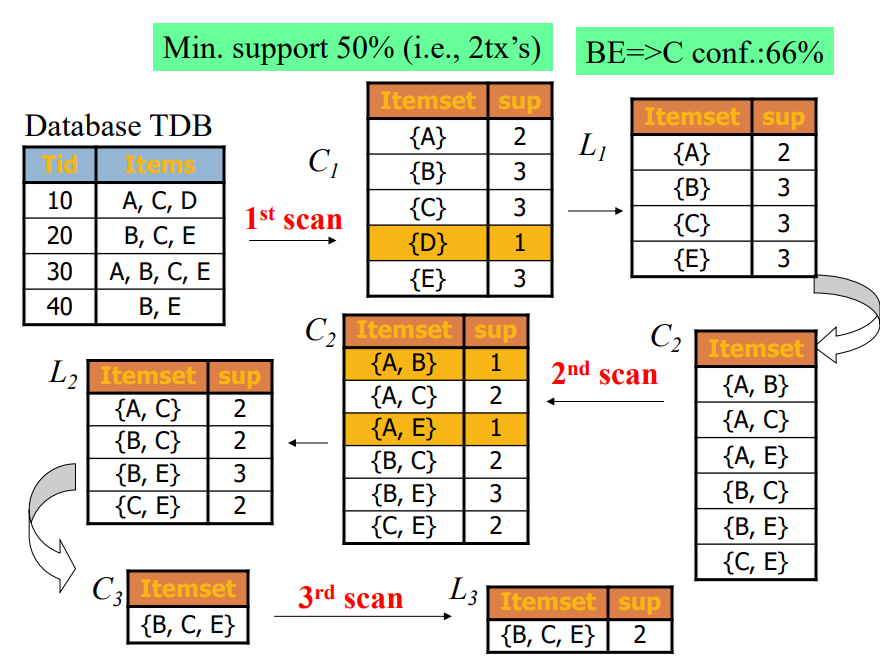

- L_k: 빈번한 k-항목 집합, 즉, k번째 반복에서 minsupport를 충족하는 빈번한 집합
- C_k: Database에서나, L_k에서 나올 수 있는 k-항목 집합, 즉, 후보 k-항목 집합, 가능한 빈번한 k-항목 집합

-----

- k-1 항목 집합을 사용하여 k 항목 집합 생성
- L[k-1]과 L[k-1]을 결합하여 C[k] 얻기
- 부분 집합 테스트를 사용하여 C[k] 정리
- MinSup을 만족하는 C[k]의 항목 집합을 추출하여 L[k] 생성

## 이거를 하나하나 뜯어서 이해해보자

In [1]:
# def apriori(itemSetList, minSup, minConf):
#     C1ItemSet = getItemSetFromList(itemSetList)
#     # Final result global frequent itemset
#     globalFreqItemSet = dict()
#     # Storing global itemset with support count
#     globalItemSetWithSup = defaultdict(int)

#     L1ItemSet = getAboveMinSup(
#         C1ItemSet, itemSetList, minSup, globalItemSetWithSup)
#     currentLSet = L1ItemSet
#     k = 2

#     # Calculating frequent item set
#     while(currentLSet):
#         # Storing frequent itemset
#         globalFreqItemSet[k-1] = currentLSet
#         # Self-joining Lk
#         candidateSet = getUnion(currentLSet, k)
#         # Perform subset testing and remove pruned supersets
#         candidateSet = pruning(candidateSet, currentLSet, k-1)
#         # Scanning itemSet for counting support
#         currentLSet = getAboveMinSup(
#             candidateSet, itemSetList, minSup, globalItemSetWithSup)
#         k += 1

#     rules = associationRule(globalFreqItemSet, globalItemSetWithSup, minConf)
#     rules.sort(key=lambda x: x[2])

#     return globalFreqItemSet, rules

## 0. 데이터 셋 호출 및 전처리

### Python 내장 csv 호출 모듈 사용 

### itemSetList 정의

In [39]:
from apriori_python import apriori
from csv import reader

f = open(r'C:\Users\is041\geon_hyeon\Git\Apriori\dataset\kaggle.csv', 'r', encoding = 'utf-8')

# reader 가 한 라인씩 읽어오면서 뒤에 들여쓰기 까지 들고와서 리스트 맨 마지막 삭제
itemSetList = list(map(lambda x: x[:-1], reader(f))) 

### itemSets, itemSet 정의

In [40]:
# def getFromFile(fname): # 전처리를 한 다음에 itemSet, itemSets를 구해줄 것이기 때문에 생략
#     itemSets = []
#     itemSet = set()

#     with open(fname, 'r') as file:
#         csv_reader = reader(file)
#         for line in csv_reader: # 한줄씩 읽어오기
#             line = list(filter(None, line)) # None 값 제거
#             record = set(line) # 중복 값 제거
#             for item in record: # 한 record에 값에 대한
#                 itemSet.add(frozenset([item]))
#             itemSets.append(record)
#     return itemSet, itemSets

In [49]:
# List[List[str]] -> List[List[str]] but None 값 제거
itemSets = list(map(lambda x: list(filter(None, x)), itemSetList))

print(itemSets[0])

['Lassi', 'Coffee Powder', 'Butter', 'Yougurt', 'Ghee', 'Cheese']


In [51]:
from itertools import chain, combinations

# List[List[str]] -> Set[frozenset]
itemSet = set(
    map(lambda item: frozenset([item]), chain(*itemSetList))
)

print(itemSet)

{frozenset({'Bread'}), frozenset({'Sugar'}), frozenset({'Butter'}), frozenset({'Lassi'}), frozenset({'Cheese'}), frozenset({'Ghee'}), frozenset({'Sweet'}), frozenset({'Panner'}), frozenset({'Milk'}), frozenset({'Coffee Powder'}), frozenset({'Tea Powder'}), frozenset({'Yougurt'})}


## 1. 필요한 함수들 정의

In [52]:
from collections import defaultdict

def getAboveMinSup(itemSet, itemSetList, minSup, globalItemSetWithSup):
    freqItemSet = set()
    localItemSetWithSup = defaultdict(int)

    for item in itemSet:
        for itemSet in itemSetList:
            if item.issubset(itemSet):
                globalItemSetWithSup[item] += 1
                localItemSetWithSup[item] += 1

    for item, supCount in localItemSetWithSup.items():
        support = float(supCount / len(itemSetList))
        if(support >= minSup):
            freqItemSet.add(item)

    return freqItemSet

In [53]:
def getUnion(itemSet, length): ## 합집합 구하기
    return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])

In [54]:
def pruning(candidateSet, prevFreqSet, length): ## 가지치기
    tempCandidateSet = candidateSet.copy()
    for item in candidateSet:
        subsets = combinations(item, length)
        for subset in subsets:
            # if the subset is not in previous K-frequent get, then remove the set
            if(frozenset(subset) not in prevFreqSet):
                tempCandidateSet.remove(item)
                break
    return tempCandidateSet

In [55]:
def associationRule(freqItemSet, itemSetWithSup, minConf):
    rules = []
    for k, itemSet in freqItemSet.items():
        for item in itemSet:
            subsets = powerset(item)
            for s in subsets:
                confidence = float(
                    itemSetWithSup[item] / itemSetWithSup[frozenset(s)])
                if(confidence > minConf):
                    rules.append([set(s), set(item.difference(s)), confidence])
    return rules

In [56]:
def getItemSetFromList(itemSetList): # 음 내 마음에 안든다 좀 바꿔봐야겠다.
    tempItemSet = set()

    for itemSet in itemSetList:
        for item in itemSet:
            tempItemSet.add(frozenset([item]))

    return tempItemSet

In [57]:
def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

## 2. A priori 알고리즘

In [58]:
def apriori(itemSetList, minSup, minConf):
    C1ItemSet = getItemSetFromList(itemSetList)
    # Final result global frequent itemset
    globalFreqItemSet = dict()
    # Storing global itemset with support count
    globalItemSetWithSup = defaultdict(int)

    L1ItemSet = getAboveMinSup(
        C1ItemSet, itemSetList, minSup, globalItemSetWithSup)
    currentLSet = L1ItemSet
    k = 2

    # Calculating frequent item set
    while(currentLSet):
        # Storing frequent itemset
        globalFreqItemSet[k-1] = currentLSet
        # Self-joining Lk
        candidateSet = getUnion(currentLSet, k)
        # Perform subset testing and remove pruned supersets
        candidateSet = pruning(candidateSet, currentLSet, k-1)
        # Scanning itemSet for counting support
        currentLSet = getAboveMinSup(
            candidateSet, itemSetList, minSup, globalItemSetWithSup)
        k += 1

    rules = associationRule(globalFreqItemSet, globalItemSetWithSup, minConf)
    rules.sort(key=lambda x: x[2])

    return globalFreqItemSet, rules

## 3. 결과

In [60]:
freqItemSet, rules = apriori(itemSetList, minSup=0.2, minConf=0.4)

print(rules)

[[{'Milk'}, {'Ghee'}, 0.4543973941368078], [{'Milk'}, {'Sweet'}, 0.45457835685848713], [{'Milk'}, {'Yougurt'}, 0.45475931958016647], [{'Milk'}, {'Bread'}, 0.4554831704668838], [{'Yougurt'}, {'Bread'}, 0.4555696892604034], [{'Milk'}, {'Coffee Powder'}, 0.45566413318856314], [{'Ghee'}, {'Lassi'}, 0.4557168784029038], [{'Ghee'}, {'Milk'}, 0.4557168784029038], [{'Coffee Powder'}, {'Lassi'}, 0.4559811218006898], [{'Ghee'}, {'Sugar'}, 0.45662431941923776], [{'Yougurt'}, {'Milk'}, 0.45666000363438125], [{'Coffee Powder'}, {'Cheese'}, 0.456888727536758], [{'Bread'}, {'Lassi'}, 0.45696571845368344], [{'Coffee Powder'}, {'Milk'}, 0.45707024868397167], [{'Bread'}, {'Yougurt'}, 0.45714806710430345], [{'Ghee'}, {'Panner'}, 0.45789473684210524], [{'Sweet'}, {'Milk'}, 0.4581433521794638], [{'Coffee Powder'}, {'Bread'}, 0.4588854601561082], [{'Sugar'}, {'Ghee'}, 0.4589565851878876], [{'Bread'}, {'Milk'}, 0.4589715536105033], [{'Ghee'}, {'Butter'}, 0.4591651542649728], [{'Milk'}, {'Lassi'}, 0.459464350

# apriori_python 직접 설치 후 실행

!pip install apriori_python

In [ ]:
# from apriori_python import apriori
# itemSetList = [['eggs', 'bacon', 'soup'],
#                 ['eggs', 'bacon', 'apple'],
#                 ['soup', 'bacon', 'banana']]
# freqItemSet, rules = apriori(itemSetList, minSup=0.5, minConf=0.5)
# print(rules)  
# # [[{'beer'}, {'rice'}, 0.6666666666666666], [{'rice'}, {'beer'}, 1.0]]
# # rules[0] --> rules[1], confidence = rules[2]

In [1]:
from apriori_python import apriori
from csv import reader

f = open(r'C:\Users\is041\geon_hyeon\Git\Apriori\dataset\kaggle.csv', 'r', encoding = 'utf-8')

# reader 가 한 라인씩 읽어오면서 뒤에 들여쓰기 까지 들고와서 리스트 맨 마지막 삭제
itemSetList = list(map(lambda x: x[:-1], reader(f))) 

freqItemSet, rules = apriori(itemSetList, minSup=0.2, minConf=0.4)

print(rules)

[[{'Milk'}, {'Ghee'}, 0.4543973941368078], [{'Milk'}, {'Sweet'}, 0.45457835685848713], [{'Milk'}, {'Yougurt'}, 0.45475931958016647], [{'Milk'}, {'Bread'}, 0.4554831704668838], [{'Yougurt'}, {'Bread'}, 0.4555696892604034], [{'Milk'}, {'Coffee Powder'}, 0.45566413318856314], [{'Ghee'}, {'Milk'}, 0.4557168784029038], [{'Ghee'}, {'Lassi'}, 0.4557168784029038], [{'Coffee Powder'}, {'Lassi'}, 0.4559811218006898], [{'Ghee'}, {'Sugar'}, 0.45662431941923776], [{'Yougurt'}, {'Milk'}, 0.45666000363438125], [{'Coffee Powder'}, {'Cheese'}, 0.456888727536758], [{'Bread'}, {'Lassi'}, 0.45696571845368344], [{'Coffee Powder'}, {'Milk'}, 0.45707024868397167], [{'Bread'}, {'Yougurt'}, 0.45714806710430345], [{'Ghee'}, {'Panner'}, 0.45789473684210524], [{'Sweet'}, {'Milk'}, 0.4581433521794638], [{'Coffee Powder'}, {'Bread'}, 0.4588854601561082], [{'Sugar'}, {'Ghee'}, 0.4589565851878876], [{'Bread'}, {'Milk'}, 0.4589715536105033], [{'Ghee'}, {'Butter'}, 0.4591651542649728], [{'Milk'}, {'Lassi'}, 0.459464350